In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import pickle
from pymc import HalfCauchy, Model, Normal, sample
print(f"Running on PyMC v{pm.__version__}")

from scipy.stats import pearsonr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.0


In [6]:
data_all = pd.read_csv("Data/10pctimpx_forJZ.csv")

S_tensor = pd.read_csv("Data/Sampling_tensor.csv", index_col=0, header=None)
line_names = pd.Series(S_tensor.index)

data = pd.read_csv("Data/10pctimpx_forJZ.csv")
print(data.shape)
data = data[np.array(data['LineType'] == "G0")  | np.array(data['LineType'] == "RIL") | np.array(data['LineType'] == "RIAIL")]
print(data.shape)
num_nas = np.isnan(data.iloc[:, 7:].to_numpy()).sum(1)
data = data[num_nas < 169] # filter all lines without genotype info
geno_all = data.iloc[:, 7:].to_numpy()
n, L = geno_all.shape

(3030, 176)
(2757, 176)


In [7]:
# rename lines
par_dict = dict(zip(['G0', 'P530', 'P563'], line_names[:3]))
Line_new = []
for row in range(data.shape[0]):
    linetype = data.iloc[row].LineType
    line_num = data.iloc[row]['Linex']
    if (linetype != "RIL")  and (linetype != "RIAIL" ):
        Line_new.append(par_dict[linetype])
    else:
        if linetype == "RIL":
            Line_new.append(linetype + "_" + str(line_num - 200))
        else: Line_new.append(linetype + "_" + str(line_num))
data.Linex = Line_new

set(line_names).difference(set(data.Linex.unique())) ## Line names are the same in the genotype file and phenotype file

{'MA530', 'MA563'}

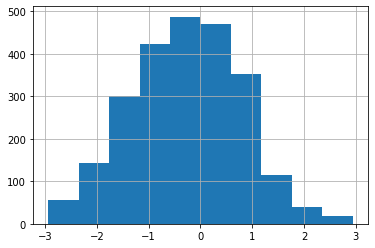

In [10]:
# Generate sparse matrix A matrix for mapping geno to geno_expand
from scipy.sparse import coo_matrix

line2num = dict(zip(line_names, range(len(line_names))))
row_idx, col_idx = np.arange(len(data)), np.array([line2num[line] for line in data.Linex])
A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))

# Turn block to dummy variables
data.block = data.block.astype("str")
block = pd.get_dummies(data.block).to_numpy()

y = data.ln_ci
y.hist()
plt.show()

In [11]:
sub = np.array([line in Focal_linetypes for line in data.LineType]) | np.array(data.LineType == 'G0') # pick subset of genotypes in Focal_linetypes
y = y[sub]
A = A.toarray()
A = A[sub]
block = block[sub]

In [8]:
import os
results_path = "Results/"
if not os.path.exists(results_path):
    os.makedirs(results_path)

### Get raw marginal effects of mutations

#### Get marginal effecs for all linetypes


In [6]:
linetypes = {'all', "RIL", "RIAIL"}

In [39]:
marg_effects_linetypes = {}

for linetype in linetypes:
    marg_effects = {}

    if linetype == 'all':
        data_ = data
    else:
        data_ = data[data.LineType == linetype]
    for i in range(1, 170):
        data_mut = np.array(data_['ln_ci'][data_['x' + str(i)]==1.])
        data_wt = np.array(data_['ln_ci'][data_['x' + str(i)]==0.])        
        # data_wt = np.array(data_['ln_ci'][data_.LineType == 'G0'])    
        boot_effects = [np.random.choice(data_mut, len(data_mut)).mean() - np.random.choice(data_wt, len(data_wt)).mean() 
                       for _ in range(100)]

        marg_effects[i] = boot_effects
    marg_effects_linetypes[linetype] = marg_effects

In [40]:
marg_data_all = {}

for linetype in linetypes:
    marg_effects_samples = pd.DataFrame(marg_effects_linetypes[linetype])
    marg_data = pd.DataFrame({'mean': marg_effects_samples.mean(), 
                              'CI2.5%': marg_effects_samples.quantile(.25), 'CI97.5%': marg_effects_samples.quantile(0.975)}) 
    if linetype == 'all':
        name = 'RIL+RIAIL'
    else: name = linetype
    marg_data_all[name] = marg_data

In [42]:
with open(results_path + "marg_effects.pkl", 'wb') as f:
    pickle.dump(marg_data_all, f)

for key in marg_data_all.keys():
    df = marg_data_all[key]
    if key == 'all':
        name = 'RIL+RIAIL'
    else: name = key
    df.to_csv(results_path + "Table_marg_effects_" + name + ".csv")

### Define models

In [10]:
def define_models():
    
    global models
    
    with pm.Model() as model_flat:  
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        likelihood = Normal("y", mu = intercept +
                            pm.math.dot(block, block_effects), sigma=std, observed=y) # likelihood


    with pm.Model() as model_unif:
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu = pm.Normal('mu', mu=0, sigma=10)

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        mut_counts = np.sum(geno_array, 1)
        likelihood = Normal("likelihood", 
                            mu=intercept 
                            + mu*mut_counts 
                            + pm.math.dot(block, block_effects), 
                            sigma=std, observed=y)    

    with pm.Model() as model_neutral_unif:  
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu = pm.Normal('mu', sigma=10)
        q = pm.Beta('p', alpha=2, beta=2) # probability of mutation being non-neutral

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        w = pm.Bernoulli('w', p=q, shape=L)

        mut_effects = pm.Deterministic('mut_effects', mu*w)

        mut_counts = np.sum(geno_array, 1)

        likelihood = Normal("y", 
                            mu=intercept
                            + pm.math.dot(geno_array, mut_effects)
                            + pm.math.dot(block, block_effects), 
                            sigma=std, observed=y)    

    with pm.Model() as model_3_effects:  
        # Define priors
        intercept = pm.Normal('intercept', mu=0, sigma=10)
        std = pm.HalfNormal('std', sigma=10)
        mu1 = pm.HalfNormal('mu1', sigma=10)
        mu2 = pm.HalfNormal('mu2', sigma=10)
        q = pm.Beta('q', alpha=2, beta=2) # prob being non-neutral
        p = pm.Beta('p', alpha=2, beta=2) # prob being positive

        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        z = pm.Bernoulli('z', p=q, shape=L) # 0/1 vector if locus is neutral
        w = pm.Bernoulli('w', p=p, shape=L) # 0/1 vector if locus is positive, conditional on being non-neutral    
        beta = pm.Deterministic('beta', z*(mu1*w - mu2*(1-w))) # mutational effects

        # Define likelihood
        likelihood = Normal("y", mu=intercept + pm.math.dot(geno_array, beta) + pm.math.dot(block, block_effects), sigma=std, observed=y)    

    with pm.Model() as model_neg_gamma:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for negative DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for negative DFE

        mut_effects = pm.Gamma("mut_effects", alpha=alpha1, beta=beta1, shape=L) #vector of negative mutation effects
        mut_effects_neg = pm.Deterministic("mut_effects_neg", -1*mut_effects) # total mutational effect
        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects_neg) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y)    


    with pm.Model() as model_1_gamma:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for positive DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for positive DFE
        p_pos = pm.Beta('p_pos', alpha=2, beta=2) # prob mutation being positive

        mut_effects_pos = pm.Gamma("mut_effects_pos", alpha=alpha1, beta=beta1, shape=L) #vector of positive mutation effects
        mut_effects_neg = pm.Gamma("mut_effects_neg", alpha=alpha1, beta=beta1, shape=L) #vector of negative mutation effects

        mask_pos = pm.Bernoulli("mask_pos", p=p_pos, shape=L) # mask for positive effects
        mask_neg = pm.Deterministic("mask_neg", mask_pos-1) # mask for negative effects    
        mut_effects = pm.Deterministic("mut_effects", mask_pos*mut_effects_pos + mask_neg*mut_effects_neg) # total mutational effect

        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y)    


    with pm.Model() as model_2_gammas:
        intercept = pm.Normal('intercept', mu=0, sigma=10) # genetic value of founder
        std = pm.HalfNormal('std', sigma=10) # std of noise 
        block_effects = pm.MvNormal('block_effects', mu=np.zeros(5), cov=np.eye(5), shape=L) # block effects

        # hyperparameters
        alpha1 = pm.HalfNormal("alpha1", sigma=10) #alpha param for positive DFE
        beta1 = pm.HalfNormal("beta1", sigma=10) #beta param for positive DFE
        alpha2 = pm.HalfNormal("alpha2", sigma=10) #alpha param for negative DFE
        beta2 = pm.HalfNormal("beta2", sigma=10) #beta param for negative DFE
        p_pos = pm.Beta('p_pos', alpha=2, beta=2) # prob mutation being positive

        mut_effects_pos = pm.Gamma("mut_effects_pos", alpha=alpha1, beta=beta1, shape=L) #vector of positive mutation effects
        mut_effects_neg = pm.Gamma("mut_effects_neg", alpha=alpha2, beta=beta2, shape=L) #vector of negative mutation effects

        mask_pos = pm.Bernoulli("mask_pos", p=p_pos, shape=L) # mask for positive effects
        mask_neg = pm.Deterministic("mask_neg", mask_pos-1) # mask for negative effects    
        mut_effects = pm.Deterministic("mut_effects", mask_pos*mut_effects_pos + mask_neg*mut_effects_neg) # total mutational effect

        likelihood = Normal("y", 
                            mu=intercept 
                            + pm.math.dot(geno_array, mut_effects) 
                            + pm.math.dot(block, block_effects)
                            , sigma=std, observed=y) # likelihood

    models = {"flat": model_flat, "unif": model_unif, "neu_unif": model_neutral_unif, 
              "3_effects": model_3_effects, "neg_gamma": model_neg_gamma,
              "1_gamma": model_1_gamma, "2_gammas": model_2_gammas}    

### Process samples

In [24]:
models_test = {"flat", "unif", "neg_gamma", "neu_unif", "3_effects", "1_gamma", "2_gammas"}

In [25]:
n_geno_reps = 40
samples = range(n_geno_reps)

In [1]:
# Define paths for output files for RIL + RIAIL, RIL, RIAIL
paths = {"all": "ALL/", "RIL": "RIL/", "RIAIL": "RIAIL/"}

In [2]:
traces_all = {}
loo_all = {}

#### Load traces

In [ ]:
for linetype in list(paths.keys()):

    A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))
    block = pd.get_dummies(data.block).to_numpy()
    y = data.ln_ci
    
    if linetype == "all":
        pass

    else: 
        sub = (data.LineType == linetype) | (data.LineType == "G0")
        y = y[sub]
        A = A.toarray()
        A = A[sub]
        block = block[sub]

    traces = {model: {} for model in models_test}

    sample_path = "Samples/" + paths[linetype]
    for i in range(n_geno_reps):
        for model in models_test:
            trace_name = "_".join(['traces', model, str(i)])
            with open(sample_path + trace_name +  '.pkl', 'rb') as file:  
                trace = pickle.load(file)
                traces[model][i] = trace

    traces_all[linetype] = traces

#### Generate posterior table

In [18]:
def get_pos(dat):
    dat = dat.data.flatten()
    r = np.array([dat.mean(), np.quantile(dat, .025),  np.quantile(dat, .975)])
    r = np.round(r, 4)
    return str(r[0]) + " (" + str(r[1]) + "," + str(r[2]) + ")"

In [19]:
model_names_dict = {
"1_gamma": "Symmetric gamma", 
"2_gammas": "Asymmetric gamma", 
"3_effects": "3 effects", 
"neg_gamma": "Negative gamma", 
"neu_unif": "Neutral + uniform", 
"unif": "Uniform", 
"flat": "Neutral"
}

In [7]:
models_test = list(models_test)

gamma_names = {'alpha1': 'alpha_pos', 'alpha2': 'alpha_neg', 'beta1': 'beta_pos', 'beta2': 'beta_neg'}

mu_names = {"mu": "u", "mu1": "u_pos", "mu2": "u_neg"}

p = 'mu1'

In [26]:
linetype = 'all'
pos_results = {}

for model in models_test:
    results_model = {}
    for linetype in linetypes:
        traces = az.concat(list(traces_all[linetype][model].values()), dim='draw')
        results = {}
        for p in traces['posterior'].keys():
                trace_p = traces['posterior'][p]
                if len(trace_p.shape) > 2:
                    if 'beta' in p:
                            pass
                    elif 'mut' in p:
                            pass
                    elif 'mask' in p:
                            pass
                    elif 'z' in p:
                            pass
                    elif 'w' in p:
                            pass

                    else:
                        for i in range(trace_p.shape[-1]):
                            r = get_pos(trace_p[:, :, i])
                            para_name = "_".join([p, str(i)])
                            results[para_name] = r
                else:
                    r = get_pos(trace_p)
                    
                    if p in mu_names.keys():
                        para_name = mu_names[p]

                    else:
                        if model == "neu_unif":
                            if p == 'p':
                                para_name = 'q'
                            else: para_name = p

                        else:
                            if p == 'p':
                                para_name = 'p_pos'
                            elif p in gamma_names.keys():
                                para_name = gamma_names[p]
                            else: para_name = p
                        
                    results[para_name] = r
                    
        if linetype == 'all':
            linetype_name = "RIL + RIAIL"
        else: linetype_name = linetype
                    
        results_model[linetype_name] = results

        pos_results[model_names_dict[model]] = results_model

In [311]:
excel_file_path = results_path + 'posteriors.xlsx'

with pd.ExcelWriter(excel_file_path) as writer:

    for model in pos_results.keys():
        df = pd.DataFrame(pos_results[model])
        df.to_excel(writer, sheet_name=model)

#### Load genotype samples

In [ ]:
geno_arrays_all = {}

for linetype in list(paths.keys()):
    
    geno_arrays = {}

    A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))
    block = pd.get_dummies(data.block).to_numpy()
    y = data.ln_ci
    
    if linetype == "all":
        pass

    else: 
        sub = (data.LineType == linetype) | (data.LineType == "G0")
        y = y[sub]
        A = A.toarray()
        A = A[sub]
        block = block[sub]

    traces = {model: {} for model in models_test}

    sample_path = "Samples/" + paths[linetype]
    for i in range(n_geno_reps):
        geno_name = "_".join(['geno_sample', str(samples[i])])
        with open(sample_path +  geno_name + '.pkl', 'rb') as file:  
            geno_array = pickle.load(file)
        
        geno_arrays[i] = geno_array
                
    geno_arrays_all[linetype] = geno_arrays

#### Calculate LOO

In [ ]:
for linetype in list(paths.keys())[1:]:

    A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))
    block = pd.get_dummies(data.block).to_numpy()
    y = data.ln_ci
    
    if linetype == "all":
        pass

    else:
        sub = (data.LineType == linetype) | (data.LineType == "G0")
        y = y[sub]
        A = A.toarray()
        A = A[sub]
        block = block[sub]

    df_loo = pd.DataFrame(columns=list(models_test), index=range(len(samples)))
    for i in samples:
        geno_array = geno_arrays_all[linetype][i]
        define_models()

        for model in models_test: 
            with models[model]:
                pm.compute_log_likelihood(traces_all[linetype][model][i])

            df_loo[model][i] = az.loo(traces_all[linetype][model][i]).elpd_loo
    df_loo.to_csv(results_path + "loo_sum_" + linetype + ".csv")  
    loo_all[linetype] = df_loo

In [ ]:
loo_sum = {}

for linetype in list(paths.keys()):
    loo_df = pd.read_csv(results_path + "loo_sum_" + linetype + ".csv", index_col = 0)
    loo_df.mean
    loo_sum[linetype] = loo_df.mean()
    loo_sum[linetype + "_Delta"] = loo_df.mean() - loo_df.mean().max()

In [ ]:
loo_sum = pd.DataFrame(loo_sum)

In [ ]:
loo_sum = loo_sum.sort_values(by = 'all', ascending=True)

In [ ]:
old_names = list(loo_sum.index)
new_names = ["Neutral", "Uniform", "Neutral + uniform", "Negative gamma", 
             "3 effects", "Asymmetric gamma", "Symmetric gamma"]

In [ ]:
new_index_names = dict(zip(old_names, new_names))
loo_sum = loo_sum.rename(index=new_index_names)

In [ ]:
loo_sum.sort_values(by = 'all', ascending=False).round(1).to_csv(results_path + "ELPD_LOO.csv")

#### Posterior means of parents

In [125]:
traces_SG = az.concat(list(traces_all['RIAIL']['2_gammas'].values()), dim='draw')

In [127]:
mut_pos = traces_SG['posterior']['mut_effects'].data.reshape(-1, 169)

In [128]:
MA530_pos = np.matmul(mut_pos, np.array(S_tensor.T['MA530'])) + intercept_pos

In [129]:
MA563_pos = np.matmul(mut_pos, np.array(S_tensor.T['MA563'])) + intercept_pos

In [130]:
print(MA530_pos.mean())
print(MA563_pos.mean())

0.11293639362676616
-0.8452970667235561


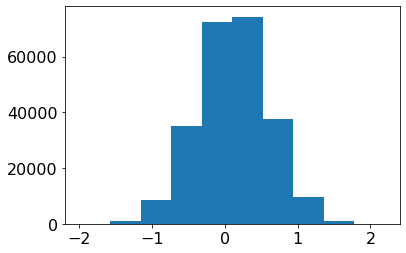

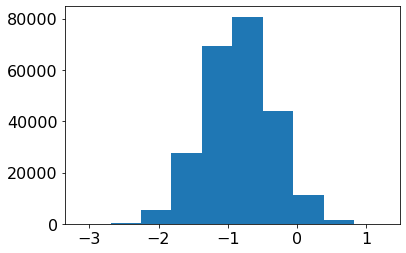

In [131]:
plt.hist(MA530_pos)
plt.show()

plt.hist(MA563_pos)
plt.show()

In [132]:
data_all[data_all.LineType == 'P530']['ln_ci'].mean()

0.2016743158646616

In [133]:
data_all[data_all.LineType == 'P563']['ln_ci'].mean()

-0.8935975878357144

#### Posterior mutation effects

In [30]:
#### Export mutation traces

mut_traces_all = {}

for linetype in paths.keys():
    traces_SG = az.concat(list(traces_all[linetype]['1_gamma'].values()), dim='draw')
    mut_traces = traces_SG.posterior['mut_effects'].data
    mut_traces = mut_traces.reshape(-1, 169)
    mut_traces_all[linetype] = mut_traces

with open(results_path + "traces_geno_mut.pkl", 'wb') as f:
    pickle.dump(mut_traces_all, f)

In [31]:
mut_data_all = {}
for linetype in paths.keys():
    traces_SG = az.concat(list(traces_all[linetype]['1_gamma'].values()), dim='draw')
    mut_traces = traces_SG.posterior['mut_effects'].data
    plotdata = pd.DataFrame({'mean': np.mean(mut_traces.reshape(-1, 169), 0), 
                            'CI2.5%': np.quantile(mut_traces.reshape(-1, 169), .025, 0), 
                            'CI97.5': np.quantile(mut_traces.reshape(-1, 169), .975, 0), 
                            'std': np.std(mut_traces.reshape(-1, 169), 0)})    
    plotdata = plotdata.rename(dict(zip(range(L), range(1, L + 1))))
    plotdata = plotdata.rename_axis('Locus')
    
    mut_data_all[linetype] = plotdata

In [224]:
with open(results_path + "mut_effects.pkl", 'wb') as f:
    pickle.dump(mut_data_all, f)

for key in mut_data_all.keys():
    df = mut_data_all[key]
    if key == 'all':
        name = 'RIL+RIAIL'
    else: name = key
    df.to_csv(results_path + "Table_posterior_mutation_effects_" + name + ".csv")